We start, as normal, by creating a `Gobnilp` object to work with:

In [1]:
from pygobnilp.gobnilp import Gobnilp
m = Gobnilp()

Using license file /home/james/gurobi.lic
Academic license - for non-commercial use only


Now we will create and store 'local scores' from the built-in `alarm_10000.dat` dataset:

In [2]:
m.learn('alarm_10000.dat',end='local scores')

Note that, since we have stated that learning should `end` after local scores have been computed and stored, a BN is not learned. The computation of these local scores is not immediate, but should not take too long. Since no local score function was specified and no data type specified either, the data will be assumed to be discrete and a BDeu score will be used. 

The local scores are saved in a dictionary which is the `local_scores` attribute of the `Gobnilp` object. The keys of this dictionary are the BN variables (the names of these variables are given on the first line of `alarm_10000.dat`). 

In [3]:
print(m.local_scores.keys())

dict_keys(['ANAPHYLAXIS', 'ARTCO2', 'BP', 'CATECHOL', 'CO', 'CVP', 'DISCONNECT', 'ERRCAUTER', 'ERRLOWOUTPUT', 'EXPCO2', 'FIO2', 'HISTORY', 'HR', 'HRBP', 'HREKG', 'HRSAT', 'HYPOVOLEMIA', 'INSUFFANESTH', 'INTUBATION', 'KINKEDTUBE', 'LVEDVOLUME', 'LVFAILURE', 'MINVOL', 'MINVOLSET', 'PAP', 'PCWP', 'PRESS', 'PULMEMBOLUS', 'PVSAT', 'SAO2', 'SHUNT', 'STROKEVOLUME', 'TPR', 'VENTALV', 'VENTLUNG', 'VENTMACH', 'VENTTUBE'])


The value associated with each BN variable is a dictionary mapping potential parent sets for that variable to a local score - which states, intuitively, how good it would be for that parent set to be selected. We find that there is variation in the number of parent sets stored:

In [4]:
for child, scored_parentsets in m.local_scores.items():
    print(child, len(scored_parentsets))

ANAPHYLAXIS 5
ARTCO2 473
BP 266
CATECHOL 383
CO 469
CVP 32
DISCONNECT 127
ERRCAUTER 22
ERRLOWOUTPUT 14
EXPCO2 176
FIO2 18
HISTORY 36
HR 154
HRBP 135
HREKG 122
HRSAT 122
HYPOVOLEMIA 57
INSUFFANESTH 1
INTUBATION 211
KINKEDTUBE 41
LVEDVOLUME 64
LVFAILURE 84
MINVOL 371
MINVOLSET 96
PAP 3
PCWP 43
PRESS 212
PULMEMBOLUS 10
PVSAT 440
SAO2 471
SHUNT 162
STROKEVOLUME 109
TPR 173
VENTALV 472
VENTLUNG 448
VENTMACH 134
VENTTUBE 317


ANAPHYLAXIS has a mere 5 parent sets whereas ARTCO2 has 473! This is because `Gobnilp` is using *pruning*. If a variable $X$ has potential parent set $S$ which is a superset of another potential parent set $T$ which has a higher score then $S$ is 'pruned' away. This is because, assuming we do not have any special constraints on allowed BNs, we can never have an optimal BN where $S$ is a parent set, since we could always replace $S$ with $T$ and get a higher scoring BN *without creating a cycle, since we would remove arrows*.

It just so happens that more parent sets were pruned for ANAPHYLAXIS than ARTCO2. Let's look at the scored parent sets for ANAPHYLAXIS:

In [5]:
for parentset, score in m.local_scores['ANAPHYLAXIS'].items():
    print(parentset, score)

frozenset() -578.587070487134
frozenset({'BP'}) -523.5582005530596
frozenset({'CATECHOL'}) -577.4536694321869
frozenset({'TPR'}) -471.48556937259855
frozenset({'BP', 'HYPOVOLEMIA'}) -518.1711042499956


The empty set has the worst score of the 5 - if any of the non-empty parent set had a worse score it would be pruned.

Each local score will be eventually be associated with a Gurobi MIP variable called a *family variable* (since it is associated with a 'child' variable and a parent set). The fewer of these family variables the better since the MIP will be smaller and thus easier for Gurobi to solve. If we have prior knowledge then this can 
1. reduce the number of local scores, and
2. reduce the time required to compute the local scores

To provide an example of how prior knowledge can help, let's see how often variables occur in the potential parent sets for ARTCO2:

In [6]:
from collections import Counter
d = Counter()
for parent_set in m.local_scores['ARTCO2']:
    for v in parent_set:
        d[v] += 1
print(d)    

Counter({'EXPCO2': 101, 'SHUNT': 98, 'INTUBATION': 93, 'DISCONNECT': 91, 'CATECHOL': 85, 'KINKEDTUBE': 75, 'MINVOLSET': 72, 'VENTMACH': 62, 'PRESS': 60, 'SAO2': 56, 'VENTLUNG': 50, 'VENTTUBE': 50, 'HR': 49, 'HREKG': 42, 'HRSAT': 42, 'HRBP': 41, 'TPR': 40, 'PVSAT': 37, 'MINVOL': 31, 'CO': 25, 'FIO2': 12, 'BP': 7, 'VENTALV': 5, 'STROKEVOLUME': 1})


So, for example KINKEDTUBE occurs in 75 parent sets. Now, suppose we knew that ARTCO2 and KINKEDTUNE had to be independent. Then we should provide this information to Gobnilp. We do this as follows:

In [7]:
m.add_obligatory_independence(['ARTCO2'],['KINKEDTUBE'])

We can recompute the local scores with this new information available:

In [8]:
m.learn(start='data',end='local scores')

And now we can check that there should be 75 fewer parents for ARTCO2, and also some reduction in the parent sets for KINKEDTUBE. 

In [9]:
print(len(m.local_scores['ARTCO2']))
print(len(m.local_scores['KINKEDTUBE']))

398
32


As expected there are $398 = 473 - 75$ fewere parent sets for ARTCO2, and also some reduction in the number of parent sets for KINKEDTUBE. This is because we asserted an independence constraint, which we can get to via the `obligatroy_conditional_indepedences` attribute:

In [10]:
m.obligatory_conditional_independences

{(frozenset({'ARTCO2'}), frozenset({'KINKEDTUBE'}), frozenset())}

Note that the independence constraint is stored as a conditional independence constraint with an empty conditioning set (the 3rd set in the tuple above). Also note that `Gobnilp` is taking advantage of this constraint before a MIP problem has been created - to help reduce the number of local scores computed. Naturally this constraint is also taken into account when learning a BN (which is done by constructing and solving a MIP model) to ensure that any learned BN satisfies the constraint.

When an independence (or conditional independence) constraint is added (by the user) `Gobnilp` deduces that certain other simpler constraints follow. In our current example, it is deduced that
1. there can be no arrow between the two variables, and
2. the two variables cannot be adjacent in the undirected skeleton

In [11]:
m.forbidden_arrows

{('ARTCO2', 'KINKEDTUBE'), ('KINKEDTUBE', 'ARTCO2')}

In [12]:
m.forbidden_adjacencies

{frozenset({'ARTCO2', 'KINKEDTUBE'})}

Next, let's learn an optimal BN and check that it satisfies the given independence constraint. Since this is a reasonably hard BN learning problem, we'll get the output from Gurobi printed out so we can at least see the progress. We do this by setting the appropriate Gurobi attribute. 

Changed value of parameter OutputFlag to 1
   Prev: 0  Min: 0  Max: 1  Default: 1
Changed value of parameter PoolSolutions to 1
   Prev: 10  Min: 1  Max: 2000000000  Default: 10
Changed value of parameter LazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Discarded solution information
Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (linux64)
Optimize a model with 2288 rows, 7349 columns and 158765 nonzeros
Model fingerprint: 0xaf366470
Variable types: 0 continuous, 7349 integer (7349 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 1e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 663 rows and 383 columns
Presolve time: 0.57s
Presolved: 1625 rows, 6966 columns, 85959 nonzeros
Variable types: 0 continuous, 6966 integer (6966 binary)
Found heuristic solution: objective -205904.1188
Presolve removed 382 rows and 0 columns
Presolved: 1245 rows, 6966 columns, 29899 nonzeros


Root relaxation: obje

  1364   724 -104978.18   24  309 -105331.82 -104813.51  0.49%   125  120s
  1432   762 -105131.71   27  336 -105331.82 -104822.06  0.48%   126  125s
  1531   749     cutoff   32      -105331.82 -104848.01  0.46%   127  130s
  1655   766 -105128.92   22  293 -105331.82 -104858.24  0.45%   130  135s
  1765   780 -105310.31   42    - -105331.82 -104882.86  0.43%   128  140s
  1845   774 -105115.98   23  300 -105331.82 -104888.75  0.42%   130  147s
  1885   777 -104991.01   19  377 -105331.82 -104898.49  0.41%   131  150s
  1960   781 -105188.38   33  212 -105331.82 -104901.96  0.41%   134  156s
  2058   782 -105330.80   33    - -105331.82 -104908.09  0.40%   135  161s
  2125   775 -105066.06   18  275 -105331.82 -104917.14  0.39%   136  165s
  2223   795 -105090.34   26  277 -105331.82 -104919.48  0.39%   137  171s
  2280   802     cutoff   23      -105331.82 -104922.58  0.39%   137  175s
  2430   812 -104965.28   21  316 -105331.82 -104929.47  0.38%   135  180s
  2532   867 -105320.86  

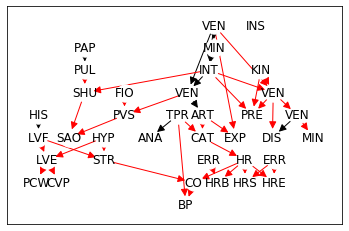

In [13]:
m.setParam('OutputFlag',True)
m.learn(start='local scores') # construct a MIP model and get Gurobi to solve it

**This cell needs updating**

Although this is quite a large network it is easy to see that ARTCO2 and KINKEDTUBE are indeed independent. This is because neither have any parents.

Gobnilp/Gurobi took quite a while (321 seconds) to find a provably optimal BN in this case (and recall that we are running with the default parent set limit of 3 - were we to raise that solving would take longer still). As is normal Gobnilp spent some time (here 73 seconds) adding cutting planes to reduce the upper bound on the score of an optimal BN from an original upper bound of -83626.171 down to -104594.63. Then Gurobi builds a search tree by branching on the values of MIP variables, finally finding a BN with a reasonable score at node 728 of this tree. Although at this point we know that the incumbent is close to the best possible BN (gap = 0.78%) it takes quite a while longer and thousands more search nodes before we can be sure we have an optimal BN. (In fact an optimal, as opposed to close-to-optimal BN, is not found until near the end of the search at node 13577.)

It is interesting to compare this to what happens when we learn from this dataset with *no extra constraints*:

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter PreCrush to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Changed value of parameter CutPasses to 100000
   Prev: -1  Min: -1  Max: 2000000000  Default: -1
Changed value of parameter GomoryPasses to 100000
   Prev: -1  Min: -1  Max: 2000000000  Default: -1
Changed value of parameter MIPFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter ZeroHalfCuts to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter MIPGap to 0.0
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Changed value of parameter MIPGapAbs to 0.0
   Prev: 1e-10  Min: 0.0  Max: inf  Default: 1e-10
Changed value of parameter PoolSolutions to 1
   Prev: 10  Min: 1  Max: 2000000000  Default: 10
Changed value of parameter LazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Discarded solution information
Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (linux64)
Optimize a model with 2

  8465  1399 -105168.13   57   52 -105226.50 -105029.93  0.19%  74.8  305s
  8716  1338     cutoff   22      -105226.50 -105040.23  0.18%  74.5  311s
  9088  1249     cutoff   35      -105226.50 -105052.35  0.17%  73.7  318s
  9469  1137 -105178.38   20   70 -105226.50 -105063.79  0.15%  72.9  324s
  9633  1137 -105192.06   39   59 -105226.50 -105072.77  0.15%  72.7  325s
  9828  1015     cutoff   38      -105226.50 -105075.42  0.14%  72.3  331s
 10195   881 -105188.10   23  105 -105226.50 -105088.51  0.13%  71.5  336s
 10485   733     cutoff   39      -105226.50 -105100.20  0.12%  71.1  341s
 10882   571     cutoff   28      -105226.50 -105113.10  0.11%  70.2  346s
 11256   393     cutoff   54      -105226.50 -105132.68  0.09%  69.3  350s

Cutting planes:
  User: 1068
  Gomory: 1
  Flow cover: 5
  Zero half: 78
  Lazy constraints: 43

Explored 12089 nodes (807784 simplex iterations) in 354.98 seconds
Thread count was 4 (of 4 available processors)

Solution count 1: -105227 
No other s

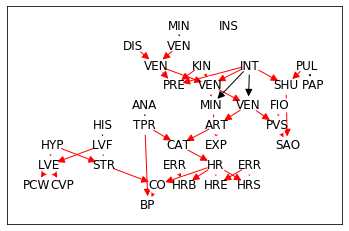

In [14]:
m2 = Gobnilp(gurobi_output=True)
m2.learn('alarm_10000.dat')

**This section needs updating**

Without the independence constraint solving takes 190 seconds (as opposed to 321 seconds), even though the set of allowed BNs is greater without the constraint. This is basically because Gobnilp is optimised for the case where the only constraint is that the BN is acyclic. 

The number of "Lazy constraints" posted in the two runs is worth examining: without the constraint there are only 8 but with the independence constraint there are 1153. This is because Gobnilp is adding constraints ruling out BNs (strictly speaking ancestral subgraphs of BNs) which do not satisfy the independence constraint. This is a crude method of enforcing (conditional) independence constraints and this adds to the slowness of solving.